In [1]:
# Daily Looping FOR SIGNALS.JS and buy.json and sell.json
from backtesting import Backtest, Strategy
import yfinance as yf
import json
import pandas as pd
import datetime
# import pandas_ta as ta
import tqdm
import subprocess
route = "../Database/"
filemap = {
    "NYSE"  : route + "../Database/zackRanks_NYSE.json", # 1352
    "NASDAQ": route + '../Database/zackRanks_NASDAQ.json', # small:1255; mid:330; large:72
    "SP500" : route + "../Database/zackRanks_SP500.json", # small: 1352
   "Yuanta": route + "zackRanks_yuanta.json",
   "buy": route + "buy.json",
   "sell": route + "sell.json",
   "portfolio": route + "zackRanks_portfolio.json"
}
def get_tickers(file="SP500"):
    dict = pd.read_csv(filemap[file], header=None)
    dict = dict.iloc[:, 0]
    return dict

def WPRbt(data):
    period = 12
    max = data.Close.rolling(period).max()
    min = data.Close.rolling(period).min()
    wpr = (max - data.Close)/(max - min) * (-100) 
    return wpr

def check_WPR_2MA_without_DB(ticker, test=False, period_long_ma=28, period_short_ma=14, upb=-20, lob=-80):
    a = yf.download(ticker, start=datetime.datetime.now() - datetime.timedelta(days=50), interval="1d", progress=False)

    # a["WPR"] = WPRbt(a)
    a["MAX"] = a.High.rolling(12).max()
    a["MIN"] = a.Low.rolling(12).min()
    a["WPRs"] = (a.MAX - a.Close)/(a.MAX - a.MIN) * (-100)
    a["long_MA"] = a.Close.ewm(span=period_long_ma, adjust=False, min_periods=period_long_ma).mean()
    a['short_MA'] = a.Close.ewm(span=period_short_ma, adjust=False, min_periods=period_short_ma).mean()
    long0 = list(a['long_MA'])[-1]
    long1 = list(a['long_MA'])[-2]
    long2 = list(a['long_MA'])[-3]
    long3 = list(a['long_MA'])[-4]
    # =======================
    short0 = list(a['short_MA'])[-1]
    short1 = list(a['short_MA'])[-2]
    short2 = list(a['short_MA'])[-3]
    short3 = list(a['short_MA'])[-4]
    # =======================
    wpr0 = list(a['WPRs'])[-1]
    wpr1 = list(a['WPRs'])[-2]
    wpr2 = list(a['WPRs'])[-3]
    wpr3 = list(a['WPRs'])[-4]
    check_ma_percent = 0.0000# for PAYX at 2024-02-08, 0.005 return 4(meaning doesn't work ) while 0.006 works
    bear_market = (long0 - short0 > long0*check_ma_percent) and (long1 - short1 > long1*check_ma_percent) and (long2 - short2 > long2*check_ma_percent)
    bull_market = (long0 - short0 < long0*-check_ma_percent) and (long1 - short1 < long1*-check_ma_percent) and (long2 - short2 < long2*-check_ma_percent)
    if test:
        print(a[['Close', "short_MA", "long_MA", "WPRs", "MAX"]])
        print(wpr0, wpr1, wpr2, wpr3)
        print("quick: ", [short3, short2, short1, short0])
        print("slow: ", [long3, long2, long1, long0])
    # current signal
    if((wpr0 < upb) and (wpr1 > upb) and bear_market):
        # print(ticker, "cross above"):
            # sell signal
        return 1
    elif ((wpr0 > lob) and (wpr1 < lob)) and bull_market:
        # buy signal
        return 2
    # check for yesterday or the day before yesterday buy/sell signal
    elif((wpr1 < upb) and (wpr2 > upb) and bear_market):
        return 1.5
    elif((wpr1 > lob) and (wpr2 < lob) and bull_market):
        return 2.5
    elif((wpr2 > lob) and (wpr3 < lob) and bull_market) or ((wpr2 > upb) and (wpr3 < upb) and bear_market):
        return 3

    else:
        return 0

def mains(loops = ["NYSE", "Yuanta", "NASDAQ", "SP500"], updateDatabase = False):
    sell_of_the_day = []
    buy_of_the_day = []
    all_signals_buy = {}
    all_signals_sell = {}
    for k in loops:
        
        print("*"*20, k, "*"*20)

        with open(filemap[k], 'r') as f:
            python_dict = json.load(f)
        a = list(python_dict.keys())
        if k in ['portfolio', "SP500", "Yuanta"]:
            tickers = a[:] 
        elif k == "NYSE":
            tickers = a[1:1352]
        elif k == "NASDAQ":
            tickers = a[1:1255]

        # Using tqdm to add a progress bar
        with tqdm.tqdm(total=len(tickers)) as pbar:
            res = {}
            for ticker in tickers:
                res[ticker] = check_WPR_2MA_without_DB(ticker)
                pbar.update(1)
                
        s = [{i:res[i]} for i in res.keys() if res[i] != 0 ]
        if sum(list(res.values())) == 0:
            print("there's nothing with signal")

        checks = [1, 2]
        for check in checks:
            q = [i for i in res.keys() if res[i] == check]
            dict_res = {}
            print(len(q))
            for ticker in q:
                command = "zacks-api " + ticker
                result = subprocess.check_output(command, shell=True)
                dict = eval(result.decode(("utf-8"))) 
                dict_res[ticker] = dict['zacksRank']
            if check == 1:
                sell = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "4"]
                strong_sell = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "5"]
                print("Strong Sell:", strong_sell)
                print("Sell: ", sell)
                res_sell = strong_sell #+ sell
                sell_of_the_day += strong_sell
                all_signals_sell = {**all_signals_sell, **dict_res}
            if check == 2:
                strong_buy = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "1"]
                buy = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "2"]
                hold_but_signal = [ticker for ticker in list(dict_res.keys()) if dict_res[ticker] == "3"]
                print("Strong Buy:", strong_buy)
                print("Buy: ", buy)
                res_buy = strong_buy #+ buy
                buy_of_the_day += strong_buy
                all_signals_buy = {**all_signals_buy, **dict_res}
            # print(json.dumps(dict_res, indent=4))

            print("=============")

        if updateDatabase:
            time = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
            with open(filemap['buy'], 'r') as f:
                python_dict = json.load(f)
            
            python_dict[k][time] = res_buy

            with open(filemap['buy'], 'w') as f:
                json.dump(python_dict, f, indent=4)

            with open(filemap['sell'], 'r') as f:
                python_dict_sell = json.load(f)
            python_dict_sell[k][time] = res_sell

            with open(filemap['sell'], 'w') as f:
                json.dump(python_dict_sell, f, indent=4)
    
    with open("../Database/signals.json", "r") as f:
        ks = json.load(f)
    ks[time] = {"buy": all_signals_buy, "sell": all_signals_sell} 
    with open("../Database/signals.json", "w") as f:
        json.dump(ks, f , indent=4)

    print("Sell: ", sell_of_the_day)
    print("Buy: ", buy_of_the_day)
    print("Hold: ", hold_but_signal)
    print({"buy": all_signals_buy, "sell": all_signals_sell})
updateDatabase = True



loops = ["NASDAQ", "NYSE", "SP500"]
mains(updateDatabase=updateDatabase, loops=loops)


c:\Users\Jamie\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


******************** NASDAQ ********************


100%|██████████| 1254/1254 [03:32<00:00,  5.90it/s]


12
Strong Sell: ['MCHP', 'SGML', 'AMRK']
Sell:  ['HSAI', 'EXPO']
10
Strong Buy: ['EZPW']
Buy:  ['HTHT']
******************** NYSE ********************


100%|██████████| 1351/1351 [03:26<00:00,  6.56it/s]


20
Strong Sell: []
Sell:  ['LEG', 'NVRI']
20
Strong Buy: ['AXS']
Buy:  ['CRBG', 'STNG', 'GL']
******************** SP500 ********************


100%|██████████| 499/499 [01:22<00:00,  6.01it/s]


6
Strong Sell: []
Sell:  []
8
Strong Buy: ['RL']
Buy:  ['GL', 'WYNN']
Sell:  ['MCHP', 'SGML', 'AMRK']
Buy:  ['EZPW', 'AXS', 'RL']
Hold:  ['TJX', 'CTVA', 'LVS', 'NWSA']
{'buy': {'HTHT': '2', 'WB': '3', 'ARVN': '3', 'COLM': '5', 'EZPW': '1', 'YY': '', 'ALXO': '3', 'SWBI': '3', 'XENE': '3', 'DGII': '3', 'CNHI': '3', 'CVX': '5', 'TJX': '3', 'LVS': '3', 'UL': '3', 'DINO': '3', 'CRBG': '2', 'BDX': '3', 'FRO': '4', 'STNG': '2', 'ADCT': '4', 'CMRE': '3', 'GL': '2', 'AXS': '1', 'CMC': '3', 'KT': '4', 'HGV': '3', 'AGS': '3', 'MBI': '4', 'AMPY': '5', 'CTVA': '3', 'NWSA': '3', 'WYNN': '2', 'RL': '1'}, 'sell': {'ERIC': '3', 'MCHP': '5', 'DXCM': '2', 'SGML': '5', 'XXII': '3', 'AVDL': '3', 'IMMX': '3', 'HSAI': '4', 'APLM': '3', 'EXPO': '4', 'AMRK': '5', 'PWFL': '3', 'CCL': '2', 'KGC': '3', 'BILL': '1', 'AA': '3', 'FSM': '3', 'ROK': '3', 'VTR': '3', 'DEA': '3', 'LEG': '4', 'LAAC': '3', 'PBI': '3', 'HCC': '3', 'TEX': '3', 'RNG': '3', 'PHG': '3', 'CALX': '3', 'PD': '3', 'ENS': '3', 'NVRI': '4', 'WSO': '

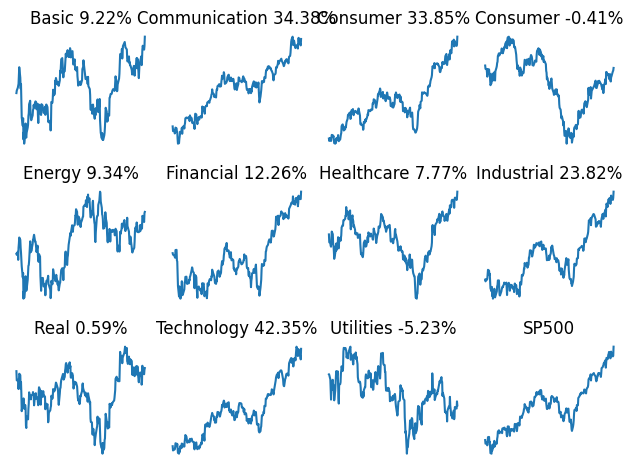

monthly : ['Technology', 'Communication', 'Industrial', 'Energy', 'Financial']
3 months : ['Technology', 'Industrial', 'Communication', 'Financial', 'Healthcare']
6  months : ['Technology', 'Communication', 'Industrial', 'Financial', 'Energy']
yearly : ['Technology', 'Communication', 'Industrial', 'Financial', 'Energy']


In [29]:
# Trend Comparison 30 sec
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf 
import json
import datetime
with open("../Database/us_stock.json", "r") as f:
  python_dict = json.load(f)
dict_return_comparison = {}
mat = list(python_dict["SP500"].keys())
fig, ax = plt.subplots(3, 4)
start = datetime.datetime.now() - datetime.timedelta(days=365)
for i, bas in enumerate(mat):
  
  a = yf.download(python_dict["SP500"][bas], start=start, progress=False)
  close = a["Close"]
  avg = close.sum(axis=1)/len(close.columns)
  percentage_change_year = round(((avg[-1]-avg[0])/avg[0])*100, 2)
  percentage_change_month = round(((avg[-1]-avg[-30])/avg[0])*100, 2)
  percentage_change_3m = round(((avg[-1]-avg[-90])/avg[0])*100, 2)
  percentage_change_6m = round(((avg[-1]-avg[-180])/avg[0])*100, 2)
  class_name = bas.split(" ")[0]
  dict_return_comparison[class_name] = [percentage_change_month, percentage_change_3m, percentage_change_6m, percentage_change_year]
  title = class_name + " " + str(percentage_change_year) + "%"
  if 0 <= i <= 3:
    ax[0, i].plot(avg)
    ax[0, i].set_title(title)
    ax[0, i].axis("off")
  if 4 <= i <= 7:
    ax[1, i-4].plot(avg)
    ax[1, i-4].set_title(title)
    ax[1, i-4].axis("off")
  if 8 <= i <= 10:
    ax[2, i-8].plot(avg)
    ax[2, i-8].set_title(title) 
    ax[2, i-8].axis("off")
k = yf.download("^GSPC",start=start, progress=False)
ax[2, 3].plot(k['Close'])
ax[2, 3].set_title("SP500")
ax[2, 3].axis("off")
plt.tight_layout()
plt.show()

comp = {
    0: "monthly",
    1: "3 months",
    2: "6  months",
    3: "yearly"
}
def geykey(item):
    return item[1]
list_ = [0, 1, 2, 3]
for interval in list_:

    sorted_dict = sorted(dict_return_comparison.items(), key=lambda x:x[1][interval], reverse=True)
    returns = {}
    for i, value in enumerate(sorted_dict):
        returns[value[0]] = dict_return_comparison[value[0]]
    print(comp[interval], ":", list(returns.keys())[:5])